In [20]:
import os
import logging
import cv2
from ast import literal_eval
import numpy as np
import random
import itertools  
import datetime as dt
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.models import load_model

IMG_SIZE = 64
BATCH_SIZE = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.keras.backend.clear_session()

In [35]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10), dpi=100)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    plt.savefig('confusion_matrix.png', dpi=100)
    plt.close()

def plot_metric(metric_name_1, metric_name_2, plot_name, model_training_history):

  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()
  plt.show()
  plt.close()
    
def create_model(image_height, image_width, model_output_size):
    model = Sequential()

    # input shape = h x w x (n * 3) --> 3 rgb channels for color and 3 rgb channels for depth...
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 4*3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()
    return model

def pre_process_dataset(features, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset
        
def create_dataset(path_dataset):
    features = []
    labels = []
    classes_list = []
    
    for entry in os.scandir(path_dataset):
        if entry.is_dir():
            classes_list.append(entry.name)
    
    df = pd.read_csv('./out.csv')
    df['Classes'] = df['Classes'].apply(literal_eval)
    
    for index, row in df.iterrows():
    
        filename = row['File']
        binary_classes = row['Classes']
        
        class_name = ''
        for idx, bit in enumerate(binary_classes):
            
            if int(bit) == 1:
                class_name = classes_list[idx]
                break
        
        
        
        img_color = cv2.imread(path_dataset+'/'+class_name+'/'+filename+'_color.jpg')
        img_depth = cv2.imread(path_dataset+'/'+class_name+'/'+filename+'_depth.jpg')
        img_gray = cv2.imread(path_dataset+'/'+class_name+'/'+filename+'_gray.jpg')
        img_border = cv2.imread(path_dataset+'/'+class_name+'/'+filename+'_border.jpg')
        
        try:
            resized_color = cv2.resize(img_color, (image_height, image_width))
            resized_depth = cv2.resize(img_depth, (image_height, image_width))
            resized_gray = cv2.resize(img_gray, (image_height, image_width))
            resized_border = cv2.resize(img_border, (image_height, image_width))
        except:
            continue
            
        normalized_color = resized_color/255
        normalized_depth = resized_depth/255
        normalized_gray = resized_gray/255
        normalized_border = resized_border/255
        
        # X
        features.append(cv2.merge([normalized_color, normalized_depth, normalized_gray, normalized_border]))
        # Y
        labels.append(binary_classes)

    features = np.asarray(features).astype(np.float32)
    labels = np.array(labels)

    return features, labels

def get_output_layers(net):

    layer_names = net.getLayerNames()

    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    #cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def object_detection_frame(args_image, args_config, args_weights):

    image = args_image.copy()

    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    net = cv2.dnn.readNet(args_weights, args_config)

    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    persons = []

    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]

        if str(classes[class_ids[i]]) == 'person':
            persons.append([round(x), round(y), round(x+w), round(y+h), COLORS[class_ids[i]]])
            draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

    #cv2.imshow("object detection", image)
    #cv2.waitKey()

    #cv2.imwrite("object-detection.jpg", image)
    #cv2.destroyAllWindows()
    return image, persons

def human_activity_detection(img_color, img_depth, img_gray, img_border, model, classes_list):
    activities = []
    label = ''

    try:
        resized_color = cv2.resize(img_color, (image_height, image_width))
        resized_depth = cv2.resize(img_depth, (image_height, image_width))
        resized_gray = cv2.resize(img_gray, (image_height, image_width))
        resized_border = cv2.resize(img_border, (image_height, image_width))
    except:
        print(img_color.shape)
        print(img_depth.shape)
        return label

    normalized_color = resized_color/255
    normalized_depth = resized_depth/255
    normalized_gray = resized_gray/255
    normalized_border = resized_border/255

    features = cv2.merge([normalized_color, normalized_depth, normalized_gray, normalized_border])

    predicted_labels_probabilities = model.predict(np.expand_dims(features, axis = 0))[0]
    avg = np.average(predicted_labels_probabilities)
        
        # running, sitting, standing, walking
        # walking_down_stairs, walking_up_stairs
        # with_mask, without_mask, wrong_use_mask
    
    dict = {}
    for lbl_idx, lbl_vle in enumerate(predicted_labels_probabilities):
        dict[classes_list[lbl_idx]] = lbl_vle

    dict_movement = {
        'running': dict['running'],
        'sitting': dict['sitting'],
        'standing': dict['standing'],
        'walking': dict['walking'],
        'walking_down_stairs': dict['walking_down_stairs'],
        'walking_up_stairs': dict['walking_up_stairs'],
        'trotinete': dict['trotinete']
    }
    
    dict_mask = {
        'with_mask': dict['with_mask'],
        'without_mask': dict['without_mask'],
        'wrong_use_mask': dict['wrong_use_mask']
    }
    
    dict_action = {
        'on_the_phone': dict['on_the_phone'],
        'writing': dict['writing']
    }
    
    max_movement_key = max(dict_movement, key=dict_movement.get)
    max_mask_key = max(dict_mask, key=dict_mask.get)

    value_movement = dict_movement[max_movement_key]
    value_mask = dict_mask[max_mask_key]
        
        
    if (value_movement >= avg):
        activities.append(max_movement_key)
    if (value_mask >= avg):
        activities.append(max_mask_key)
    for action_key in dict_action:
        if (dict[action_key] >= avg):
            activities.append(action_key)


    for activity in activities:
        if label == '':
            label = str(activity)
        else:
            label = str(label) + '/' + str(activity)
    return label

In [3]:
path_dataset = './dataset'

image_height, image_width = IMG_SIZE, IMG_SIZE
classes_list = []

for entry in os.scandir(path_dataset):
    if entry.is_dir():
        classes_list.append(entry.name)
model_output_size = len(classes_list)

features, labels = create_dataset(path_dataset)
#one_hot_encoded_labels = to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size = 0.8, shuffle = True, random_state = seed_constant)


In [4]:
model = load_model('model.h5')

In [5]:
# model = create_model(image_height, image_width, model_output_size)

# plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

# # Adding Early Stopping Callback
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# # Adding loss, optimizer and metrics values to the model.
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss = 'categorical_crossentropy', 
#               metrics = ['accuracy'])

# # Start Training
# model_training_history = model.fit(x = x_train, 
#                                    y = y_train,
#                                    batch_size = BATCH_SIZE,
#                                    shuffle = True,
#                                    epochs = 30,
#                                    validation_split = 0.2,
#                                    callbacks = [early_stopping_callback]
#                                   )
# # model_training_history = model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 2 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


In [6]:
# model_evaluation_history = model.evaluate(x_test, y_test)

# # Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
# model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# # Saving your Model
# model.save(model_name)

Confusion matrix, without normalization
[[ 60   0   0   0   0   1   0   0   0  10   0   0]
 [  0  11   0   0   0  19   0   0   0   0   3   0]
 [  0   0  13   4   0  11   0   0 107 311   0   0]
 [  0   0   0 262   0 224   0   1   0 204   0   1]
 [  0   0   0   0   2  17   0   0   0   0   0   4]
 [  2   3   5   8   1 994  17  31   2  21   1   5]
 [  0   0   0   0   0  40  65   7   0   5   0   0]
 [  0   0   0   0   0  25  36  68   0   5   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  14   0   0   2   0   0   0  50   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


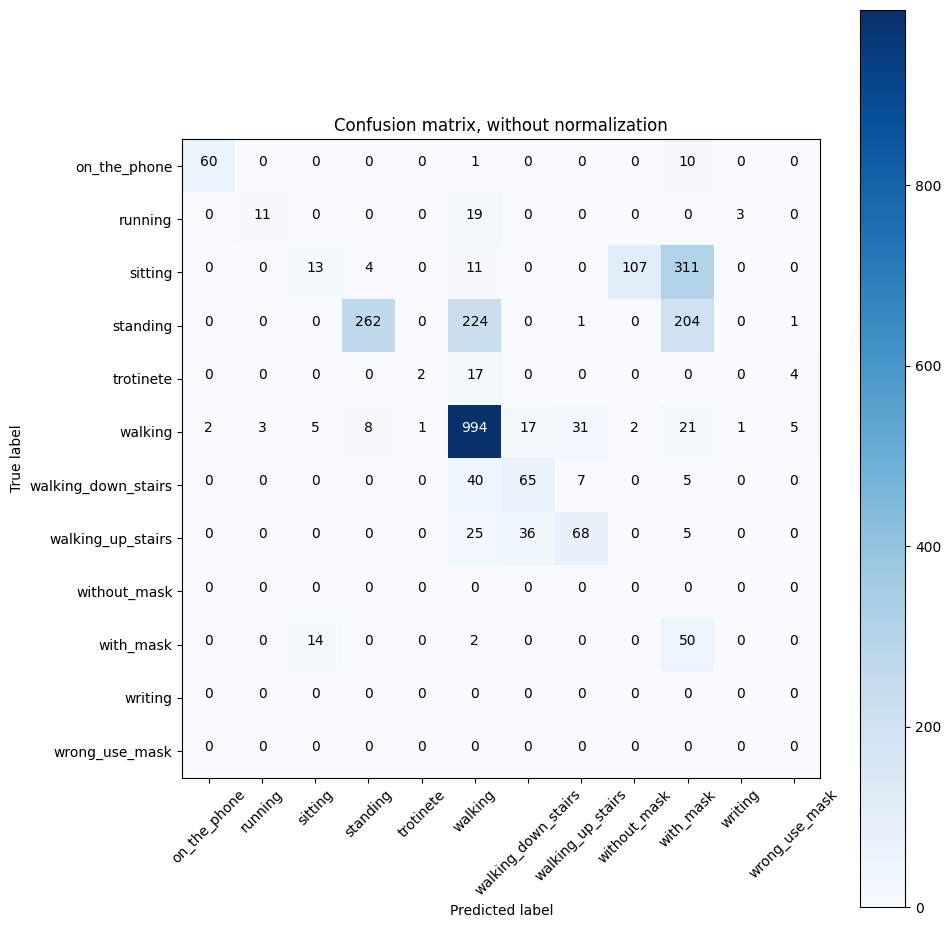

In [36]:
y_pred = model.predict(features)

cnf_matrix = confusion_matrix(np.argmax(labels, axis=1), np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=classes_list,
                      title='Confusion matrix, without normalization')

In [7]:
# plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss', model_training_history)
# plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy', model_training_history)

In [ ]:
args_config = "./yolov3.cfg"
args_weights = "./yolov3.weights"
args_classes = "./yolov3.txt"

video_path = './videos/'
video = '00112'
video_color = 'video_color_escada_'
video_depth = 'video_depth_escada_'
video_out = './output/'+video+'.mov'

#out_path = './Samples/'

classes = None
with open(args_classes, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))


v_color = str(video_path) + str(video_color) + str(video) + str('.mov')
v_depth = str(video_path) + str(video_depth) + str(video) + str('.mov')

cap = cv2.VideoCapture(str(v_color))
cap_depth = cv2.VideoCapture(str(v_depth))

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(video_out, cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

if (cap.isOpened() == False):
    print("Error opening color video file")

if (cap_depth.isOpened() == False):
    print("Error opening depth video file")
    
while (cap.isOpened() & cap_depth.isOpened()):
    ret, frame = cap.read()
    ret_d, frame_d = cap_depth.read()
    if (ret == True & ret_d == True):

        frame_yolo, persons = object_detection_frame(frame, args_config, args_weights)

        for p in persons:
        # x1, y1, x2, y2 
            x1 = p[0]
            y1 = p[1]
            x2 = p[2]
            y2 = p[3]
            color = p[4]
            try:
                img_person = frame[y1:y2, x1:x2]
                img_depth = frame_d[y1:y2, x1:x2]

                img_gray = np.stack((cv2.equalizeHist(cv2.cvtColor(img_person, cv2.COLOR_BGR2GRAY)),) * 3, axis=-1)
                img_border = img_person - cv2.erode(img_person, np.ones((3,3), np.uint8), iterations=1)

                activities = human_activity_detection(img_person, img_depth, img_gray, img_border, model, classes_list)

                cv2.putText(frame_yolo, activities, (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            except:
                print(img_person.shape)
                print(img_depth.shape)
        
        cv2.putText(frame_yolo, 'Count_Persons = ' + str(len(persons)), (0, frame_yolo.shape[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        out.write(frame_yolo)
        cv2.imshow('Output', frame_yolo)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cap_depth.release()
out.release()
cv2.destroyAllWindows()

(156, 0, 3)
(156, 0, 3)
(166, 0, 3)
(166, 0, 3)
(156, 0, 3)
(156, 0, 3)
(148, 0, 3)
(148, 0, 3)
(130, 0, 3)
(130, 0, 3)
(130, 0, 3)
(130, 0, 3)
(130, 0, 3)
(130, 0, 3)
(136, 0, 3)
(136, 0, 3)
(156, 0, 3)
(156, 0, 3)
(118, 0, 3)
(118, 0, 3)
(116, 0, 3)
(116, 0, 3)
(192, 0, 3)
(192, 0, 3)
(196, 0, 3)
(196, 0, 3)
(184, 0, 3)
(184, 0, 3)
(210, 0, 3)
(210, 0, 3)
(108, 0, 3)
(108, 0, 3)
